# Bibliotecas

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from obterDados import obterSimbolo
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

# Obtendo dados

In [ ]:
rawDataM5 = obterSimbolo('WDO$N')
rawDataM5

In [ ]:
rawDataM5 = rawDataM5.drop(columns=['spread'])
rawDataM5['hour'] = rawDataM5.index.hour
rawNP = rawDataM5.to_numpy()
rawNP

# Tratamento de Dados

### Gerando colunas com preços passados

In [4]:
nPassado = 1000
nFuturo = 24
histNp = np.zeros((len(rawNP)-(nPassado+nFuturo), nPassado, 7))
for i in tqdm(range(len(histNp))):
    histNp[i] = rawNP[i:i+nPassado]

100%|██████████| 98975/98975 [00:03<00:00, 25127.50it/s]


### Achar quando comprar, vender ou fazer nada

In [5]:
pontos = 30
y = np.zeros((len(histNp)))
# y[:, 0] = 1
for i in tqdm(range(len(y))):
    ultimoPreco = histNp[i, -1, 3]
    for j in range(nFuturo):
        # nao fazer nada se for mais de 14hs
        if rawNP[nPassado+i+j, -1] > 14:
            break
        # comprar
        if rawNP[nPassado+i+j, 1] >= ultimoPreco + pontos:
            y[i] = 1
            break
        # vender
        if rawNP[nPassado+i+j, 2] <= ultimoPreco - pontos:
            y[i] = 2
            break


100%|██████████| 98975/98975 [00:01<00:00, 56465.58it/s]


### Normalização

In [6]:
histNpNorm = np.zeros(histNp.shape)
for i in tqdm(range(len(histNpNorm))):
    # preços
    vmax = histNp[i, :, :4].max()
    vmin = histNp[i, :, :4].min()
    histNpNorm[i, :, :4] = (histNp[i, :, :4] - vmin) / (vmax - vmin)
    # tick volume
    vmax = histNp[i, :, 4].max()
    vmin = histNp[i, :, 4].min()
    histNpNorm[i, :, 4] = (histNp[i, :, 4] - vmin) / (vmax - vmin)
    # real volume
    vmax = histNp[i, :, 5].max()
    vmin = histNp[i, :, 5].min()
    histNpNorm[i, :, 5] = (histNp[i, :, 5] - vmin) / (vmax - vmin)
    # hora
    histNpNorm[i, :, 6] = histNp[i, :, 6] / 24


100%|██████████| 98975/98975 [01:07<00:00, 1464.96it/s]


### Reshape para 2d

In [7]:
x = np.reshape(histNpNorm, (histNpNorm.shape[0], histNpNorm.shape[1] * histNpNorm.shape[2]))

### Balanceamento de Classes

[76497 10871 11607]


([<matplotlib.patches.Wedge at 0x1ecf323d630>,
 [Text(-0.8316974699896298, 0.719916188464219, '0.0'),
  Text(0.5166155074023258, -0.9711376923544044, '1.0'),
  Text(1.0261868416523983, -0.39615724910630606, '2.0')])

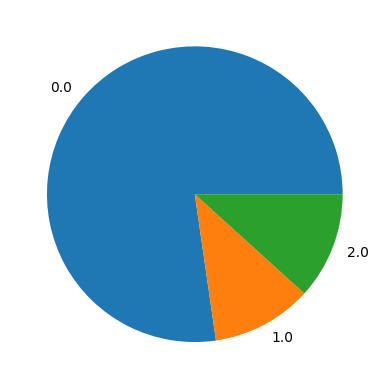

In [8]:
unicos, contagem = np.unique(y, return_counts=True)
print(contagem)
plt.pie(contagem, labels=unicos)

[10871 10871 10871]


([<matplotlib.patches.Wedge at 0x1ecf3646230>,
 [Text(0.5499999702695115, 0.9526279613277875, '0.0'),
  Text(-1.0999999999999954, -1.0298943258065002e-07, '1.0'),
  Text(0.5500001486524352, -0.9526278583383436, '2.0')])

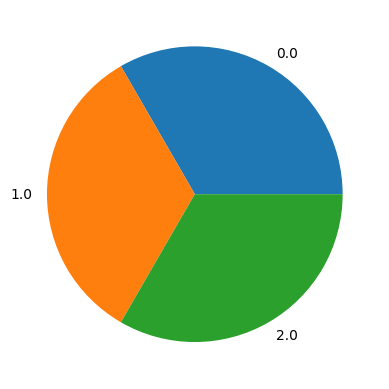

In [9]:
amostra = contagem.min()
Amostragem = np.zeros((amostra * 3, x.shape[1] + 1))

for i in range(3):
    xClasse_i = x[y == i]
    xAmostra = xClasse_i[np.random.choice(xClasse_i.shape[0], size=amostra, replace=False)]
    Amostragem[i*amostra:(i+1)*amostra, :-1] = xAmostra
    Amostragem[i*amostra:(i+1)*amostra, -1] = i

np.random.shuffle(Amostragem)
x = Amostragem[:, :-1]
y = Amostragem[:, -1]

unicos, contagem = np.unique(y, return_counts=True)
print(contagem)
plt.pie(contagem, labels=unicos)

### Separar dados de treino e teste

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Criar Modelo

### Lazy Classifier

In [11]:
from lazypredict.Supervised import LazyClassifier

lazyReg = LazyClassifier()
lazyReg.fit(x_train, x_test, y_train, y_test)

  0%|          | 0/29 [00:00<?, ?it/s]

### Criando um dos modelos encontrados

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pickle

# modelo = MLPClassifier(verbose=True)
# modelo = AdaBoostClassifier()
modelo = XGBClassifier(objective="multi:softprob")
# modelo.fit(x_train, y_train, sample_weight=pesos)
modelo.fit(x_train, y_train)
# pickle.dump(modelo, open('models/modeloClassificadorMLP.pickle', 'wb'))
# pickle.dump(modelo, open('models/modeloClassificadorAdaBoost.pickle', 'wb'))
pickle.dump(modelo, open('models/modeloClassificadorXGBoost.pickle', 'wb'))

# Pontuação de treino e teste

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from pickle import load

modelo = load(open('models/modeloClassificadorXGBoost.pickle', 'rb'))

In [ ]:
print(classification_report(y_train, modelo.predict(x_train)))

In [ ]:
print(classification_report(y_test, modelo.predict(x_test)))

In [ ]:
ConfusionMatrixDisplay.from_estimator(modelo, x_train, y_train)

In [ ]:
ConfusionMatrixDisplay.from_estimator(modelo, x_test, y_test)

# Teste Finaceiro

In [ ]:
from json import dumps

target = 30
stop = 10
timeLimit = 24
total = 0
long = False
short = False
position = 0
candle = -1
operacoes = {
    'longSuccess' : [0, 0],
    'longFail' : [0, 0],
    'longEndSuccess' : [0, 0],
    'longEndFail' : [0, 0],
    'shortSuccess' : [0, 0],
    'shortFail' : [0, 0],
    'shortEndSuccess' : [0, 0],
    'shortEndFail' : [0, 0],
}
for i in tqdm(range(len(x_test))):
    priceNow = rawNP[-(splitDays+nPassado):][i+nPassado, 3]
    if long:
        if priceNow >= position + target:
            total += priceNow - position
            long = False
            operacoes['longSuccess'][0] += 1
            operacoes['longSuccess'][1] += priceNow - position
        if priceNow <= position - stop:
            total += priceNow - position
            long = False
            operacoes['longFail'][0] += 1
            operacoes['longFail'][1] += priceNow - position
        if i >= candle + timeLimit:
            total += priceNow - position
            long = False
            if priceNow - position > 0:
                operacoes['longEndSuccess'][0] += 1
                operacoes['longEndSuccess'][1] += priceNow - position
            else:
                operacoes['longEndFail'][0] += 1
                operacoes['longEndFail'][1] += priceNow - position
        continue
    if short:
        if priceNow <= position - target:
            total += position - priceNow
            short = False
            operacoes['shortSuccess'][0] += 1
            operacoes['shortSuccess'][1] += position - priceNow
        if priceNow >= position + stop:
            total += position - priceNow
            short = False
            operacoes['shortFail'][0] += 1
            operacoes['shortFail'][1] += position - priceNow
        if i >= candle + timeLimit:
            total += position - priceNow
            short = False
            if position - priceNow > 0:
                operacoes['shortEndSuccess'][0] += 1
                operacoes['shortEndSuccess'][1] += position - priceNow
            else:
                operacoes['shortEndFail'][0] += 1
                operacoes['shortEndFail'][1] += position - priceNow
        continue

    previsao = modelo.predict([x_test[i]])[0]
    if previsao == 1:
        long = True
        position = priceNow
        candle = i
    if previsao == 2:
        short = True
        position = priceNow
        candle = i

print('Total:', total)
print('Operações: ', dumps(operacoes, indent=4))